Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
dropout_60 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 3136)            

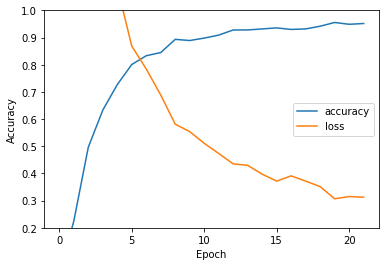

In [33]:
import cv2
import pickle
import os.path
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.python import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from helpers import resize_to_fit  

# # 不区分大小写的字母文件夹
# LETTER_IMAGES_FOLDER = "extracted_letter_images"
# # 不区分大小写的模型保存位置
# MODEL_FILENAME = "captcha_model.hdf5"
# # 不区分大小写的转换对象保存位置
# MODEL_LABELS_FILENAME = "model_labels.dat"

# 区分大小写的文件夹
LETTER_IMAGES_FOLDER = "extracted_letter_images_"
# 区分大小写的模型保存位置
MODEL_FILENAME = "captcha_model_.hdf5"
# 区分大小写的转换对象保存位置
MODEL_LABELS_FILENAME = "model_labels_.dat"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):   # 1
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)                           # 2   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)          # 3 

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 30, 30) # 引入的函数

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]                # 4
    if len(label)==2: 
        label = label[0]
   
    # Add the letter image and it's label to our training data
    data.append(image)
    #print(data)
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)    
    
# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.2, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train) # 构建一个转换对象
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)                                      # 5


# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(32, (3, 3), 
                 padding="same", 
                 input_shape=(30, 30, 1), 
                 activation="relu",
                 kernel_regularizer = keras.regularizers.l2(0.01),
                 bias_regularizer = keras.regularizers.l2(0.01))) # 6
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(64, (3, 3), 
                 padding="same", 
                 activation="relu" ,
                 kernel_regularizer = keras.regularizers.l2(0.01)))                 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Third convolutional layer
model.add(Conv2D(64, (3, 3), 
                 padding="same", 
                 activation="relu",
                 kernel_regularizer = keras.regularizers.l2(0.01)))

# Add Dropout layer to avoid overfitting
model.add(Dropout(0.4))
# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))#  kernel_regularizer=keras.regularizers.l2(0.01)
# model.add(Dense(500, activation="relu"))
# Add Dropout layer to avoid overfitting
model.add(Dropout(0.3))

# Output layer with 36/62 nodes (one for each possible letter/number we predict)
# model.add(Dense(36, activation="softmax"))
model.add(Dense(62, activation="softmax"))


model.build()
model.summary()

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Train the neural network
# model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)
history = model.fit(X_train, Y_train, epochs=22, validation_data=(X_test, Y_test), batch_size=32)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='center right')

model.evaluate(X_test, Y_test)

# model.save_weights('model_weights.h5')

# Save the trained model to disk
model.save(MODEL_FILENAME)

1. 列出路径下的文件名或图片名并且存入list列表，进行for循环取出，构建绝对路径即可对该文件进行遍历操作。
2. imread函数有两个参数，第一个参数是图片路径，第二个参数表示读取图片的形式，有三种：
   cv2.IMREAD_COLOR：加载彩色图片，这个是默认参数，可以直接写1。
   cv2.IMREAD_GRAYSCALE：以灰度模式加载图片，可以直接写0。
   cv2.IMREAD_UNCHANGED：包括alpha，可以直接写-1
3. p1是需要转换的图片，p2是转换成何种格式。
   cv2.COLOR_BGR2RGB 将BGR格式转换成RGB格式
   cv2.COLOR_BGR2GRAY 将BGR格式转换成灰度图片
4. os.path.sep:路径分隔符  linux下是’/’
5. 一、dump()方法
    pickle.dump(obj, file, [,protocol])
    注释：序列化对象，将对象obj保存到文件file中去。参数protocol是序列化模式，默认是0（ASCII协议，表示以文本的形式进行序列化），protocol的值   还可以是1和2（1和2表示以二进制的形式进行序列化。其中，1是老式的二进制协议；2是新二进制协议）。file表示保存到的类文件对象，file必须有       write()接口，file可以是一个以'w'打开的文件或者是一个StringIO对象，也可以是任何可以实现write()接口的对象。
   二、load()方法
    pickle.load(file)
   注释：反序列化对象，将文件中的数据解析为一个python对象。file中有read()接口和readline()接口
6. conv2d主要实现了输入张量与设定卷积核的卷积操作
    tf.nn.conv2d(
    input,  输入
    filter,  卷积核
    strides,  滑动步长
    padding,   图像边沿填充的方式
    use_cudnn_on_gpu=True,
    data_format='NHWC',
    dilations=[1, 1, 1, 1],
    name=None
)
